# Some analysis of the demographics of India

In this Notebook we will analyse some of the tables of data at https://en.wikipedia.org/wiki/Demographics_of_India relating to the demographics of India.
First, we will obtain a local copy of the HTML file so we don't have to keep fetching it from the internet. We will save it in a subdirectory specified by the variable `HTML_DIR`.

In [1]:
import os
import urllib

# The directory we're going to save local copies of the HTML files into.
HTML_DIR = 'html'
if not os.path.exists(HTML_DIR):
    os.mkdir(HTML_DIR)

In [2]:
def get_htmlpath(filename):
    """Get qualified path to local HTML file filename."""
    return os.path.join(HTML_DIR, filename)

def fetch_html(url, filename):
    """Fetch HTML file for continent from internet and save as filename."""

    print('Fetching HTML file from', url, '...')
    req = urllib.request.urlopen(url)
    html = req.read().decode()
    filepath = get_htmlpath(filename)
    print('Saving as', filepath, '...')
    with open(filepath, 'w') as fo:
        fo.write(html)

In [3]:
url = 'https://en.wikipedia.org/wiki/Demographics_of_India'
filename = 'india-demographics.html'
fetch_html(url, filename)

Fetching HTML file from https://en.wikipedia.org/wiki/Demographics_of_India ...
Saving as html/india-demographics.html ...


In [4]:
# Check the file is there:
!ls -l $HTML_DIR

total 1008
-rw-r--r--  1 christian  staff  513046  2 Aug 14:10 india-demographics.html


We're in business. First some imports and configuration for our Jupyter session:

In [5]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# I want to always display warnings
import warnings
np.seterr(all='warn')
warnings.simplefilter("always")

Now read the data tables into a list of pandas `DataFrames`:

In [6]:
data = pd.read_html(os.path.join(HTML_DIR, filename))
print(f'Read in {len(data)} HTML tables.')

Read in 36 HTML tables.


## Population statistics

The first one I'm interested in lists the some population distribution by states and union territories and turns out to be at index 8. We'll make a copy into the object `df` so that we can always check it against the original if we need to. We'll also do some tidying in the following lines:

* set the state / UT name as the index;
* strip out "(UT") from the union territory names;
* drop some of the redundant columns (we will re-create some of these);
* rename some of the columns to get rid of the footnote numbers; and
* drop the last row, which contains the totals / summary statistics of the columns.

In [7]:
# Population distribution by states / union territories (2011)
df = data[8].copy()
df.set_index('State/UT', inplace=True)
# Match index labels against strings that end in " (UT)" and strip this part:
df.rename({e: re.sub(r'(.+)\s\(UT\)$',r'\1', e) for e in df.index}, inplace=True)
df.drop(['Rank', 'Percent (%)', 'Population[52]', 'Difference between male and female',
         'Sex Ratio', 'Density (per km2)'], axis='columns', inplace=True)
df.rename({'Rural[53]': 'Rural', 'Urban[53]': 'Urban', 'Area[54] (km2)': 'Area (km2)',
           'Male': 'Male Population', 'Female': 'Female Population'},
          axis='columns', inplace=True)
df.drop('Total (India)', inplace=True)

In [8]:
df

,Male Population,Female Population,Rural,Urban,Area (km2)
State/UT,,,,,
Uttar Pradesh,104480510,95331831,155111022,44470455,240928
Maharashtra,58243056,54131277,61545441,50827531,307713
Bihar,54278157,49821295,92075028,11729609,94163
West Bengal,46809027,44467088,62213676,29134060,88752
Madhya Pradesh,37612306,35014503,52537899,20059666,308245
Tamil Nadu,36137975,36009055,37189229,34949729,130058
Rajasthan,35550997,32997440,51540236,17080776,342239
Karnataka,30966657,30128640,37552529,23578175,191791
Gujarat,31491260,28948432,34670817,25712811,196024


Now let's recreate columns for each state for the total population, sex ratio (number of women per 1000 men) and population density and produce some summary statistics:

In [9]:
df['Population'] = df['Male Population'] + df['Female Population']
df['Sex Ratio'] = df['Female Population'] / df['Male Population'] * 1000
df['Population density (km-2)'] = df['Population'] / df['Area (km2)']

In [10]:
total_pop = df['Population'].sum()
print('Total population of India (2011): {:,}'.format(total_pop))
state_sr_min = df['Sex Ratio'].idxmin()
print('Lowest sex ratio: F:M * 1000 = {:.1f} ({})'.format(df.loc[state_sr_min]['Sex Ratio'], state_sr_min))
state_sr_max = df['Sex Ratio'].idxmax()
print('Highest sex ratio: F:M * 1000 = {:.1f} ({})'.format(df.loc[state_sr_max]['Sex Ratio'], state_sr_max))
state_least_dense = df['Population density (km-2)'].idxmin()
print('Lowest population density: {:.1f} km-2 ({})'.format(
        df.loc[state_least_dense]['Population density (km-2)'], state_least_dense))

mean_pop_density = total_pop / df['Area (km2)'].sum()
print('Aveage population density of India: {:.1f} km-2'.format(mean_pop_density))

Total population of India (2011): 1,210,754,977
Lowest sex ratio: F:M * 1000 = 618.4 (Daman and Diu)
Highest sex ratio: F:M * 1000 = 1084.3 (Kerala)
Lowest population density: 16.5 km-2 (Arunachal Pradesh)
Aveage population density of India: 368.3 km-2


## Literacy

Next, let's look at the table on literacy rates, which turns out to be the one indexed at 16. We'll do some more cleaning after obtaining a copy of the `DataFrame` first:

In [11]:
df_lit = data[16][:-1].copy()
df_lit.set_index('State or UT', inplace=True)
df_lit.rename({e: re.sub(r'(.+)\s\(UT\)',r'\1', e) for e in df.index}, inplace=True)
df_lit.rename(index={'Andhra Pradesh[74]': 'Andhra Pradesh'}, inplace=True)
df_lit.drop('State or UT code', axis='columns', inplace=True)
df_lit

,Overall (%),Male (%),Female (%)
State or UT,,,
Jammu and Kashmir,86.61,87.26,86.23
Himachal Pradesh,83.78,90.83,76.60
Punjab,76.60,81.48,71.34
Chandigarh,86.43,90.54,81.38
Uttarakhand,79.63,88.33,70.70
Haryana,76.64,85.38,66.77
Delhi,86.34,91.03,80.93
Rajasthan,67.06,80.51,52.66
Uttar Pradesh,69.72,79.24,59.26


We'd like to combine this table with the existing one, `df`, which is also indexed by state / UT name:

In [12]:
df[['Male Literacy (%)', 'Female Literacy (%)']] = df_lit[['Male (%)', 'Female (%)']]
df

,Male Population,Female Population,Rural,Urban,Area (km2),Population,Sex Ratio,Population density (km-2),Male Literacy (%),Female Literacy (%)
State/UT,,,,,,,,,,
Uttar Pradesh,104480510,95331831,155111022,44470455,240928,199812341,912.436501,829.344622,79.24,59.26
Maharashtra,58243056,54131277,61545441,50827531,307713,112374333,929.403103,365.192023,89.82,75.48
Bihar,54278157,49821295,92075028,11729609,94163,104099452,917.888480,1105.523953,73.39,53.33
West Bengal,46809027,44467088,62213676,29134060,88752,91276115,949.968219,1028.440091,82.67,71.16
Madhya Pradesh,37612306,35014503,52537899,20059666,308245,72626809,930.932100,235.613908,80.53,60.02
Tamil Nadu,36137975,36009055,37189229,34949729,130058,72147030,996.432562,554.729659,86.81,73.86
Rajasthan,35550997,32997440,51540236,17080776,342239,68548437,928.172000,200.294055,80.51,52.66
Karnataka,30966657,30128640,37552529,23578175,191791,61095297,972.938086,318.551428,82.85,68.13
Gujarat,31491260,28948432,34670817,25712811,196024,60439692,919.252897,308.328021,87.23,70.73


We can see we have a problem: there's no literacy data in our table for the state of Telangana. If we want the total literacy rate for the whole of India, we cannot therefore simply take a population-weighted sum of the literacy columns:

In [13]:
weights = df['Male Population'] / df['Male Population'].sum()
(df['Male Literacy (%)'] * weights).sum()  # wrong

79.96883256461174

Instead, we need to form the weighted sum over only the population rows which are not null in the literacy column. This gives:

In [14]:
male_weights = df['Male Population'][df['Male Literacy (%)'].notnull()].sum()
total_male_literacy = (df['Male Literacy (%)'] * df['Male Population'] / male_weights).sum()
female_weights = df['Female Population'][df['Female Literacy (%)'].notnull()].sum()
total_female_literacy = (df['Female Literacy (%)'] * df['Female Population'] / female_weights).sum()
print('Total male literacy rate: {:.1f} %'.format(total_male_literacy))
print('Total female literacy rate: {:.1f} %'.format(total_female_literacy))

Total male literacy rate: 82.3 %
Total female literacy rate: 65.7 %


## Comparison with per capita GDP

The Wikipedia page at https://en.wikipedia.org/wiki/List_of_Indian_states_and_union_territories_by_GDP provides a table of nominal GSDP (gross state domestic product) for the years since 2011.

Again, we'll start by taking a local copy:

In [15]:
url = 'https://en.wikipedia.org/wiki/List_of_Indian_states_and_union_territories_by_GDP'
gdsp_filename = 'india-gdsp.html'
fetch_html(url, gdsp_filename)

Fetching HTML file from https://en.wikipedia.org/wiki/List_of_Indian_states_and_union_territories_by_GDP ...
Saving as html/india-gdsp.html ...


In [16]:
!ls -l $HTML_DIR

total 1288
-rw-r--r--  1 christian  staff  513046  2 Aug 14:10 india-demographics.html
-rw-r--r--  1 christian  staff  141104  2 Aug 14:10 india-gdsp.html


In [17]:
# NB missing values appear in the tables as '–'
gdsp_data = pd.read_html(os.path.join(HTML_DIR, gdsp_filename), na_values='–')
print(f'Read in {len(gdsp_data)} HTML tables.')

Read in 8 HTML tables.


More tidying:

In [18]:
gdf = gdsp_data[3]
gdf.set_index('State/Union territory', inplace=True)
gdf.index.name = 'State/UT'
gdf.drop('India', inplace=True)
gdf.dropna(axis='columns', inplace=True)
df['GSDP (₹ crore)'] = gdf.iloc[:,0]

A more useful measure would be the per capita GSDP:

In [19]:
df['GSDP per head (₹)'] = df['GSDP (₹ crore)'] / df['Population'] * 1.e7

Let's plot some statistics:

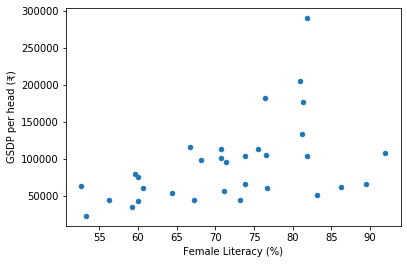

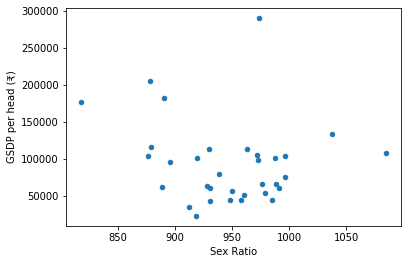

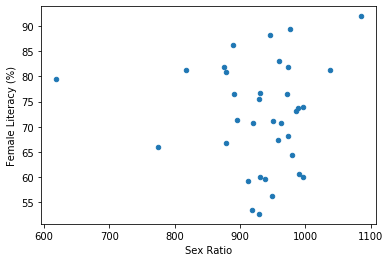

In [20]:
df.plot.scatter('Female Literacy (%)', 'GSDP per head (₹)')
df.plot.scatter('Sex Ratio', 'GSDP per head (₹)')
df.plot.scatter('Sex Ratio', 'Female Literacy (%)')

## Crime Rates

In [21]:
url = 'https://en.wikipedia.org/wiki/List_of_states_and_union_territories_of_India_by_crime_rate'
crime_filename = 'india-crime.html'
fetch_html(url, crime_filename)

Fetching HTML file from https://en.wikipedia.org/wiki/List_of_states_and_union_territories_of_India_by_crime_rate ...
Saving as html/india-crime.html ...


In [22]:
crime_data = pd.read_html(os.path.join(HTML_DIR, crime_filename), na_values='–')
print(f'Read in {len(crime_data)} HTML tables.')

Read in 2 HTML tables.


In [23]:
cdf = crime_data[1]
cdf.set_index('State/UT', inplace=True)
df['Crime Rate'] = cdf['Rate of Cognizable Crimes (2016)']

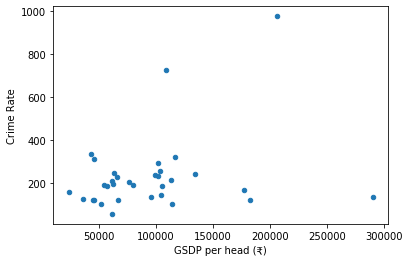

In [24]:
df.plot.scatter('GSDP per head (₹)', 'Crime Rate')

## Fertility Rates

In [25]:
url = 'https://en.wikipedia.org/wiki/List_of_states_and_union_territories_of_India_by_fertility_rate'
fertility_filename = 'india-fertility.html'
fetch_html(url, fertility_filename)

Fetching HTML file from https://en.wikipedia.org/wiki/List_of_states_and_union_territories_of_India_by_fertility_rate ...
Saving as html/india-fertility.html ...


In [26]:
fertility_data = pd.read_html(os.path.join(HTML_DIR, fertility_filename), na_values='-')
print(f'Read in {len(fertility_data)} HTML tables.')

Read in 2 HTML tables.


This one requires quite a bit of cleaning and sorting.

In [27]:
fdf = fertility_data[0].copy()
fdf.set_index('State/UT', inplace=True)
fdf.drop('India', inplace=True)
fdf.rename({'Andaman & Nicobar': 'Andaman and Nicobar Islands', 'Daman & Diu': 'Daman and Diu',
            'Puduchery': 'Puducherry', 'Dadra Nagar Haveli': 'Dadra and Nagar Haveli'}, inplace=True)

In [28]:
df['Fertility Rate'] = pd.to_numeric(fdf['Fertility rate 2009 [2]'].replace(r'\*', '', regex=True))
df

,Male Population,Female Population,Rural,Urban,Area (km2),Population,Sex Ratio,Population density (km-2),Male Literacy (%),Female Literacy (%),GSDP (₹ crore),GSDP per head (₹),Crime Rate,Fertility Rate
State/UT,,,,,,,,,,,,,,
Uttar Pradesh,104480510,95331831,155111022,44470455,240928,199812341,912.436501,829.344622,79.24,59.26,724049.0,36236.450480,128.70,3.7
Maharashtra,58243056,54131277,61545441,50827531,307713,112374333,929.403103,365.192023,89.82,75.48,1280369.0,113937.850915,217.10,1.9
Bihar,54278157,49821295,92075028,11729609,94163,104099452,917.888480,1105.523953,73.39,53.33,247144.0,23741.143229,157.40,3.9
West Bengal,46809027,44467088,62213676,29134060,88752,91276115,949.968219,1028.440091,82.67,71.16,520485.0,57023.132503,188.20,1.9
Madhya Pradesh,37612306,35014503,52537899,20059666,308245,72626809,930.932100,235.613908,80.53,60.02,315561.0,43449.657825,337.90,3.3
Tamil Nadu,36137975,36009055,37189229,34949729,130058,72147030,996.432562,554.729659,86.81,73.86,751485.0,104160.212832,258.80,1.7
Rajasthan,35550997,32997440,51540236,17080776,342239,68548437,928.172000,200.294055,80.51,52.66,436465.0,63672.494823,246.20,3.3
Karnataka,30966657,30128640,37552529,23578175,191791,61095297,972.938086,318.551428,82.85,68.13,606010.0,99190.940998,237.20,1.9
Gujarat,31491260,28948432,34670817,25712811,196024,60439692,919.252897,308.328021,87.23,70.73,615606.0,101854.589199,233.20,2.5


Is there an (inverse) correlation between female literacy and ferility?

In [29]:
df['Female Literacy (%)'].corr(df['Fertility Rate'])

-0.7361949271996956

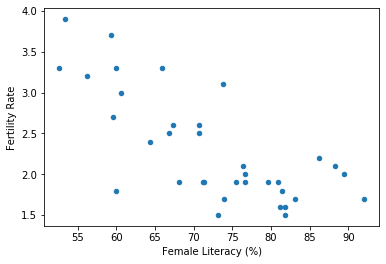

In [30]:
df.plot.scatter('Female Literacy (%)', 'Fertility Rate')

As expected, there is a strong anti-correlation of fertility rate with female literacy. _Note_: there is no reason to expect the relationship to be linear, however.